In [1]:
# code refactored from Magnus Erik Hvass Pedersen tutorials

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math

class Util(object):
    
    def plot_image(self, image, img_shape=(28,28)):
        plt.imshow(image.reshape(img_shape),
                   interpolation='nearest',
                   cmap='binary')

        plt.show()
    
    def plot_images(self, images, cls_true, cls_pred=None, img_size=28, img_shape=(28,28)):
        assert len(images) == len(cls_true) == 9

        # Create figure with 3x3 sub-plots.
        fig, axes = plt.subplots(3, 3)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()
    
    def plot_history(self, history, metric='acc', loc='lower right'): 
        # list all data in history
        # print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric])
        if metric == 'acc': 
            metric = 'accuracy'
        plt.title('model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc=loc)
        plt.show()

    def plot_images_2(self, images, cls_true, class_names, cls_pred=None, smooth=True):
        assert len(images) == len(cls_true) == 9

        # Create figure with sub-plots.
        fig, axes = plt.subplots(3, 3)

        # Adjust vertical spacing if we need to print ensemble and best-net.
        if cls_pred is None:
            hspace = 0.3
        else:
            hspace = 0.6
        fig.subplots_adjust(hspace=hspace, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Interpolation type.
            if smooth:
                interpolation = 'spline16'
            else:
                interpolation = 'nearest'

            # Plot image.
            ax.imshow(images[i, :, :, :],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()

    def print_test_accuracy(self, session, data, x, y_true, y_pred_cls, num_classes, 
                            show_example_errors=False,
                            show_confusion_matrix=False):

        # Split the test-set into smaller batches of this size.
        test_batch_size = 256

        # Number of images in the test-set.
        num_test = len(data.test.images)

        # Allocate an array for the predicted classes which
        # will be calculated in batches and filled into this array.
        cls_pred = np.zeros(shape=num_test, dtype=np.int)

        # Now calculate the predicted classes for the batches.
        # We will just iterate through all the batches.
        # There might be a more clever and Pythonic way of doing this.

        # The starting index for the next batch is denoted i.
        i = 0

        while i < num_test:
            # The ending index for the next batch is denoted j.
            j = min(i + test_batch_size, num_test)

            # Get the images from the test-set between index i and j.
            images = data.test.images[i:j, :]

            # Get the associated labels.
            labels = data.test.labels[i:j, :]

            # Create a feed-dict with these images and labels.
            feed_dict = {x: images,
                         y_true: labels}

            # Calculate the predicted class using TensorFlow.
            cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

            # Set the start-index for the next batch to the
            # end-index of the current batch.
            i = j

        # Convenience variable for the true class-numbers of the test-set.
        cls_true = data.test.cls

        # Create a boolean array whether each image is correctly classified.
        correct = (cls_true == cls_pred)

        # Calculate the number of correctly classified images.
        # When summing a boolean array, False means 0 and True means 1.
        correct_sum = correct.sum()

        # Classification accuracy is the number of correctly classified
        # images divided by the total number of images in the test-set.
        acc = float(correct_sum) / num_test

        # Print the accuracy.
        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, num_test))

        # Plot some examples of mis-classifications, if desired.
        if show_example_errors:
            print("Example errors:")
            self.plot_example_errors(data=data, cls_pred=cls_pred, correct=correct)

        # Plot the confusion matrix, if desired.
        if show_confusion_matrix:
            print("Confusion Matrix:")
            self.plot_confusion_matrix(data=data, num_classes=num_classes, cls_pred=cls_pred)


    def plot_confusion_matrix(self, data, num_classes, cls_pred):
        # This is called from print_test_accuracy() below.

        # cls_pred is an array of the predicted class-number for
        # all images in the test-set.

        # Get the true classifications for the test-set.
        cls_true = data.test.cls

        # Get the confusion matrix using sklearn.
        cm = confusion_matrix(y_true=cls_true,
                              y_pred=cls_pred)

        # Print the confusion matrix as text.
        print(cm)

        # Plot the confusion matrix as an image.
        plt.matshow(cm)

        # Make various adjustments to the plot.
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, range(num_classes))
        plt.yticks(tick_marks, range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()

    def plot_example_errors(self, data, cls_pred, correct):
        # This function is called from print_test_accuracy() below.

        # cls_pred is an array of the predicted class-number for
        # all images in the test-set.

        # correct is a boolean array whether the predicted class
        # is equal to the true class for each image in the test-set.

        # Negate the boolean array.
        incorrect = (correct == False)

        # Get the images from the test-set that have been
        # incorrectly classified.
        images = data.test.images[incorrect]

        # Get the predicted classes for those images.
        cls_pred = cls_pred[incorrect]

        # Get the true classes for those images.
        cls_true = data.test.cls[incorrect]

        # Plot the first 9 images.
        self.plot_images(images=images[0:9],
                    cls_true=cls_true[0:9],
                    cls_pred=cls_pred[0:9])


    def plot_weights(self, session, weights, img_shape=(28,28)):
        # Get the values for the weights from the TensorFlow variable.
        w = session.run(weights)

        # Get the lowest and highest values for the weights.
        # This is used to correct the colour intensity across
        # the images so they can be compared with each other.
        w_min = np.min(w)
        w_max = np.max(w)

        # Create figure with 3x4 sub-plots,
        # where the last 2 sub-plots are unused.
        fig, axes = plt.subplots(3, 4)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Only use the weights for the first 10 sub-plots.
            if i<10:
                # Get the weights for the i'th digit and reshape it.
                # Note that w.shape == (img_size_flat, 10)
                image = w[:, i].reshape(img_shape)

                # Set the label for the sub-plot.
                ax.set_xlabel("Weights: {0}".format(i))

                # Plot the image.
                ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

            # Remove ticks from each sub-plot.
            ax.set_xticks([])
            ax.set_yticks([])
            
    def plot_conv_weights(self, session, weights, input_channel=0):
        # Assume weights are TensorFlow ops for 4-dim variables
        # e.g. weights_conv1 or weights_conv2.

        # Retrieve the values of the weight-variables from TensorFlow.
        # A feed-dict is not necessary because nothing is calculated.
        w = session.run(weights)

        # Get the lowest and highest values for the weights.
        # This is used to correct the colour intensity across
        # the images so they can be compared with each other.
        w_min = np.min(w)
        w_max = np.max(w)

        # Number of filters used in the conv. layer.
        num_filters = w.shape[3]

        # Number of grids to plot.
        # Rounded-up, square-root of the number of filters.
        num_grids = math.ceil(math.sqrt(num_filters))

        # Create figure with a grid of sub-plots.
        fig, axes = plt.subplots(num_grids, num_grids)

        # Plot all the filter-weights.
        for i, ax in enumerate(axes.flat):
            # Only plot the valid filter-weights.
            if i<num_filters:
                # Get the weights for the i'th filter of the input channel.
                # See new_conv_layer() for details on the format
                # of this 4-dim tensor.
                img = w[:, :, input_channel, i]

                # Plot image.
                ax.imshow(img, vmin=w_min, vmax=w_max,
                          interpolation='nearest', cmap='seismic')

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()
        
        
    def plot_conv_layer(self, session, x, layer, image):
        # Assume layer is a TensorFlow op that outputs a 4-dim tensor
        # which is the output of a convolutional layer,
        # e.g. layer_conv1 or layer_conv2.

        # Create a feed-dict containing just one image.
        # Note that we don't need to feed y_true because it is
        # not used in this calculation.
        feed_dict = {x: [image]}

        # Calculate and retrieve the output values of the layer
        # when inputting that image.
        values = session.run(layer, feed_dict=feed_dict)

        # Number of filters used in the conv. layer.
        num_filters = values.shape[3]

        # Number of grids to plot.
        # Rounded-up, square-root of the number of filters.
        num_grids = math.ceil(math.sqrt(num_filters))

        # Create figure with a grid of sub-plots.
        fig, axes = plt.subplots(num_grids, num_grids)

        # Plot the output images of all the filters.
        for i, ax in enumerate(axes.flat):
            # Only plot the images for valid filters.
            if i<num_filters:
                # Get the output image of using the i'th filter.
                # See new_conv_layer() for details on the format
                # of this 4-dim tensor.
                img = values[0, :, :, i]

                # Plot image.
                ax.imshow(img, interpolation='nearest', cmap='binary')

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()
        
        
    def plot_transfer_values(self, i, images, transfer_values):
        print("Input image:")

        # Plot the i'th image from the test-set.
        plt.imshow(images[i], interpolation='nearest')
        plt.show()

        print("Transfer-values for the image using Inception model:")

        # Transform the transfer-values into an image.
        img = transfer_values[i]
        img = img.reshape((32, 64))

        # Plot the image for the transfer-values.
        plt.imshow(img, interpolation='nearest', cmap='Reds')
        plt.show()
        
    def plot_scatter(self, values, cls, num_classes):
        # Create a color-map with a different color for each class.
        import matplotlib.cm as cm
        cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

        # Get the color for each sample.
        colors = cmap[cls]

        # Extract the x- and y-values.
        x = values[:, 0]
        y = values[:, 1]

        # Plot it.
        plt.scatter(x, y, color=colors)
        plt.show()

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np

#from util import Util
u = Util()

tf.__version__

'1.2.1'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [8]:
data.test.labels[0:1, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

In [5]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [9]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [10]:
def plot_images(images, cls_true, cls_pred=None): 
    u.plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred, img_size=img_size, img_shape=img_shape)

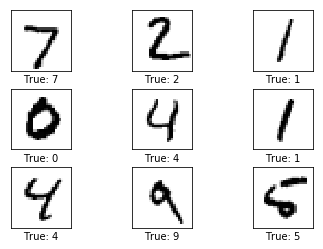

In [11]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images,cls_true=cls_true)

In [12]:
x = tf.placeholder(tf.float32,shape=[None,img_size_flat])

In [13]:
y_true = tf.placeholder(tf.float32,shape=[None,num_classes])

In [14]:
y_true_cls = tf.placeholder(tf.int64,[None])

In [15]:
weights = tf.Variable(tf.zeros([img_size_flat ,num_classes]))

In [16]:
biases = tf.Variable(tf.zeros([num_classes]))

In [17]:
logits = tf.add(tf.matmul(x,weights),biases)

In [18]:
y_pred = tf.nn.softmax(logits)

In [19]:
y_pred_cls = tf.argmax(y_pred,dimension=1)

In [20]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=logits)

In [21]:
cost = tf.reduce_mean(cross_entropy)

In [22]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

In [23]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)
accuracy = tf.reduce_mean(tf.argmax(tf.cast(correct_prediction,tf.float32)))

In [24]:
session = tf.Session()

In [25]:
init = tf.global_variables_initializer()
session.run(init)

In [26]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size=256)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [27]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [28]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False): 
    u.print_test_accuracy(session=session, data=data, x=x, y_true=y_true, y_pred_cls=y_pred_cls, num_classes=num_classes, 
                          show_example_errors=show_example_errors, show_confusion_matrix=show_confusion_matrix)

In [29]:
def plot_weights():
    u.plot_weights(session=session, weights=weights, img_shape=img_shape)

Accuracy on Test-Set: 9.8% (980 / 10000)
Example errors:


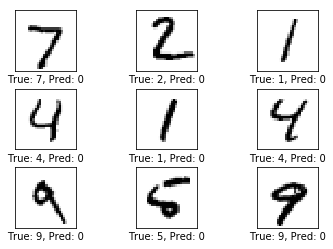

Confusion Matrix:
[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]


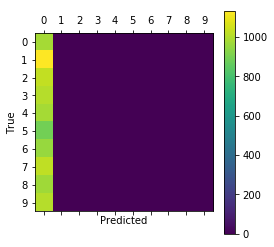

In [30]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [31]:
optimize(num_iterations=1)

Accuracy on Test-Set: 46.8% (4682 / 10000)
Example errors:


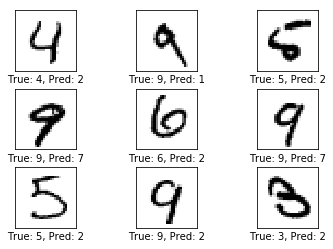

In [32]:
print_test_accuracy(show_example_errors=True)

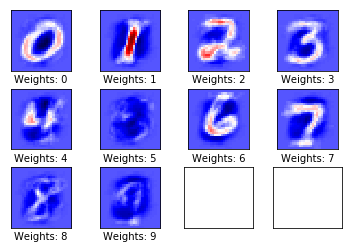

In [33]:
plot_weights()

Accuracy on Test-Set: 65.1% (6508 / 10000)
Example errors:


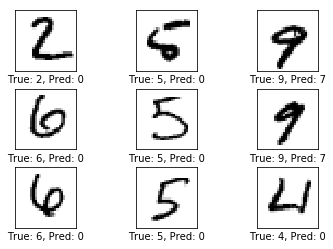

In [34]:
optimize(num_iterations=9)
print_test_accuracy(show_example_errors=True)

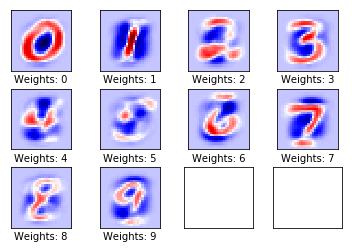

In [35]:
plot_weights()

Accuracy on Test-Set: 87.2% (8722 / 10000)
Example errors:


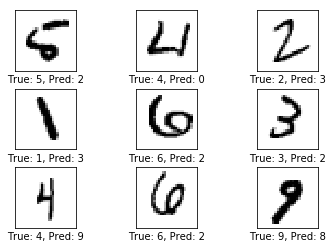

In [36]:
# We have already performed 10 iterations.
optimize(num_iterations=990)
print_test_accuracy(show_example_errors=True)

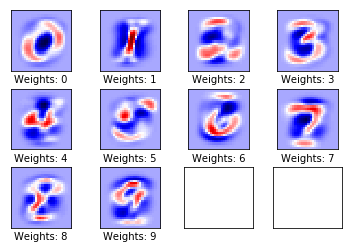

In [37]:
plot_weights()

Accuracy on Test-Set: 91.1% (9111 / 10000)
Example errors:


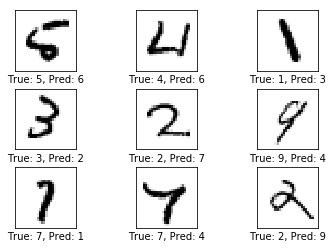

In [38]:
# We have already performed 10000 iterations.
optimize(num_iterations=10000)
print_test_accuracy(show_example_errors=True)

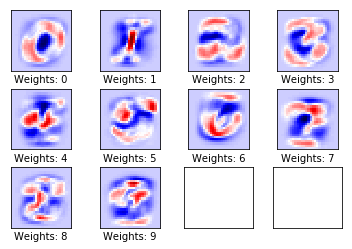

In [39]:
plot_weights()

Accuracy on Test-Set: 91.1% (9111 / 10000)
Confusion Matrix:
[[ 958    0    2    2    1    4    9    1    3    0]
 [   0 1103    2    4    1    2    4    1   18    0]
 [  11    7  900   15   15    1   16   18   40    9]
 [   5    1   20  905    1   30    3   13   21   11]
 [   1    3    6    1  913    1   10    1    8   38]
 [  11    4    3   41   11  756   16   10   31    9]
 [  15    3    5    2   14   16  900    1    2    0]
 [   3   16   22    7    9    0    0  933    3   35]
 [   8    9    9   27    8   25   13   15  847   13]
 [  11    8    5   11   41   11    0   20    6  896]]


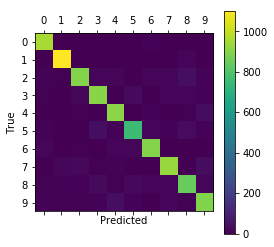

In [40]:
print_test_accuracy(show_confusion_matrix=True)

In [41]:
session.close()